# Configuration

## Install Dependencies

In [1]:
!sudo apt-get update
!sudo apt-get install build-essential cmake
!sudo apt-get install libopenblas-dev liblapack-dev 
!sudo apt-get install libx11-dev libgtk-3-dev
!sudo apt-get install python python-dev python-pip
!sudo apt-get install python3 python3-dev python3-pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

## Mount the Drive to get access to dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls
%cd 'drive/My Drive/Adversarially Trained Drive Up'

Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/Adversarially Trained Drive Up


## Check Available GPU in Google Collab

In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Change Current Directory to the Project Directory
This will be useful when we read the files because now we are at the same level as the dataset folders.

In [4]:
%cd '/content/drive/My Drive/Adversarially Trained Drive Up'
!ls

/content/drive/My Drive/Adversarially Trained Drive Up
dataset       model-eye.json  model-face.json  results-face.csv
model-eye.h5  model-face.h5   results-eye.csv  robust_sleepnets.ipynb


## Install Python Dependencies

In [5]:
!pip3 install numpy
!pip3 install dlib
!pip3 install scipy Pillow
!pip3 install adversarial-robustness-toolbox
!pip3 install ipywidgets

     |████████████████████████████████| 890kB 8.8MB/s 
     |████████████████████████████████| 21.6MB 47.4MB/s 
     |████████████████████████████████| 235kB 45.1MB/s 
     |████████████████████████████████| 6.8MB 39.1MB/s 
     |████████████████████████████████| 747kB 42.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Util Functions

In [8]:
import os
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def collect_eye_generators(augment_data=False):
    # Setup non-augmented data parameters
    ROTATION_RANGE=0   
    WIDTH_SHIFT_RANGE=0
    HEIGHT_SHIFT_RANGE=0
    SHEAR_RANGE=0
    ZOOM_RANGE=0
    HORIZONTAL_FLIP=False

    if augment_data:
        print("[INFO] Data is augmented.")
        ROTATION_RANGE=40      ## Adding these augment the training data
        WIDTH_SHIFT_RANGE=0.2  ## yields slightly lower accuracy values.
        HEIGHT_SHIFT_RANGE=0.2
        SHEAR_RANGE=0.2
        ZOOM_RANGE=0.2
        HORIZONTAL_FLIP=True
            
    IMG_SIZE = 24
    print("[INFO] loading images...")
    train_datagen = ImageDataGenerator(
		rotation_range=ROTATION_RANGE,    
		width_shift_range=WIDTH_SHIFT_RANGE, 
        height_shift_range=HEIGHT_SHIFT_RANGE,
        shear_range=SHEAR_RANGE,
        zoom_range=ZOOM_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
		rescale=1./255,
		validation_split=0.2)
    print("[INFO] Training data info:")
    train_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-eye",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='training'
	)

    print("[INFO] Validation data info:")
    val_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-eye",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="grayscale",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='validation'
	)
	
    test_datagen = ImageDataGenerator(	
		  rescale=1./255,
	)
    print("[INFO] Testing data info:")
    test_generator = test_datagen.flow_from_directory(
        directory="dataset/test-eye",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="grayscale",
        shuffle = False,
        class_mode='binary',
        batch_size=1
	)

    return train_generator, val_generator, test_generator

def save_model(model, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Saving {} model".format(model_type))
    model_json = model.to_json()
    model_file_name = "model-{}".format(model_type)
    with open(model_file_name +".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_file_name + ".h5")

def determine_img_size_from_model_type(model_type):
    return 24 if model_type == 'eye' else 100

# custom metrics
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))

def load_model(model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] loading {} model".format(model_type))
    model_file_name = "model-{}".format(model_type)
    json_file = open(model_file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_file_name + ".h5")
    loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    return loaded_model

def train(train_generator, val_generator, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Training {} model".format(model_type))
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    print('[INFO] Initialize Neural Network')
    model = Sequential()
    IMG_SIZE = determine_img_size_from_model_type(model_type)

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    EPOCHS = 4
    print("[INFO] Training network for {} epochs...".format(EPOCHS))

    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=val_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=EPOCHS)
 
    save_model(model, model_type)
    return history
    
def predict_single_image(img, model):
    img = Image.fromarray(img, 'RGB').convert('L')
    img = img.resize((IMG_SIZE,IMG_SIZE)).astype('float32')
    img /= 255
    img = img.reshape(1,IMG_SIZE,IMG_SIZE,1)
    prediction = model.predict(img)
    if prediction < 0.5:
        prediction = 'closed'
    elif prediction >= 0.5:
        prediction = 'open'
    return prediction

# Plot Accuracy and Loss
def plot_training_loss(history):
	# Plot training & validation accuracy values
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Model accuracy')
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

	# Plot training & validation loss values
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

from sklearn.metrics import classification_report, confusion_matrix
def evaluate(test_generator, model_type):
    # evaluate the network
    model = load_model(model_type)
    print("[INFO] Evaluating network...")
    X_test, y_test = next(test_generator)
    score = model.evaluate(X_test, y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1] * 100)
    print('Test precision:', score[2] * 100)
    print('Test recall:', score[3] * 100)
    print('Test f1_score:', score[4] * 100)

    
    predictions = model.predict(X_test) # predictions will be float numbers between
										# 0 and 1.
    predictions = (predictions > 0.5)    
    print(classification_report(y_test,
    predictions, target_names=['closed','open']))


import pandas as pd

def predict_with_generator(train_generator, test_generator, model_type):
    model = load_model(model_type)
    print("[INFO] Making predictions based on test dataset...")
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    test_generator.reset()
    pred=model.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST,
                                verbose=1)
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k[0]] for k in pred]
    filenames=test_generator.filenames
    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions})
    print("[INFO] Results:", results)
    print("[INFO] Predictions are completed. Results are written to csv.")
    results_csv_file_name = "results-{}.csv".format(model_type)
    results.to_csv(results_csv_file_name,index=False)

    #Confusion Matrix and Classification Report
    print('[INFO] Classification Report for model: {}'.format(model_type))
    print(classification_report(test_generator.classes,
    pred))

    print('[INFO] Confusion Matrix for model: {}'.format(model_type))
    print(confusion_matrix(test_generator.classes, pred))

# Create a TFLite Model for Mobile Applications
# This is useful because if we ever put the model into a moble device, we need a 
# model optimized and adapted for mobile applications. TFLite will help us in that. 
def create_tflite_model(model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    with open('./model-{}.json'.format(model_type), 'r') as f:
        model = tf.keras.models.model_from_json(f.read())

    # Load weights into the new model
    model.load_weights('./model-{}.h5'.format(model_type))
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("converted_model_{}.tflite".format(model_type), "wb").write(tflite_model);
    print('[INFO] Model {} is converted to TensorFlow Lite Model'.format(model_type))

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

# Display images
def display_images_from_dataset(model_type, augment_data, rows=2, columns = 4, w=10, h=10):
    """Displays 2 rows x 4 columns images (by default) from the dataset"""

    fig=plt.figure(figsize=(4*rows, 3* columns))
    np.random.seed(123)

    IMG_SIZE =  determine_img_size_from_model_type(model_type)

    if model_type == "eye":
        print("[INFO] Eye images are plotted")
        _, val_generator, _  = collect_eye_generators(augment_data)
        TARGET_SHAPE = (IMG_SIZE, IMG_SIZE)
        CMAP = 'gray'
        print("[INFO] Eye generators are collected.")
    elif model_type == "face":
        print("[INFO] Face images are plotted")
        _, val_generator , _  = collect_face_generators(augment_data)
        TARGET_SHAPE = (IMG_SIZE, IMG_SIZE)
        CMAP = ''
        print("[INFO] Face generators are collected.")
    else:
        print("[INFO] Model not supported. Exiting.")
        return -1
    
    X_train, y_train = extract_x_y_data_from_generator(val_generator)
    print("[INFO] X_train and y_train data are extracted.")
    
    closed_filtered = (X_train[i] for i in range(len(X_train)) if y_train[i] == 0)
    closed_images = list(islice(closed_filtered, columns))
    closed_filenames_generator = (i for i in range(len(X_train)) if y_train[i] == 0)
    closed_filenames = [val_generator.filenames[i] for i in list(islice(closed_filenames_generator, columns))]

    open_filtered = (X_train[i] for i in range(len(X_train)) if y_train[i] == 1)
    open_images = list(islice(open_filtered, columns))
    open_filenames_generator = (i for i in range(len(X_train)) if y_train[i] == 1)
    open_filenames = [val_generator.filenames[i] for i in list(islice(open_filenames_generator, columns))]

    print("[INFO] IMG_SIZE determined to be {}".format(IMG_SIZE))
    for i in range(1, columns*rows +1):
        if i<columns+1:
            image = closed_images[i%columns]            
        else:
            image = open_images[i%columns]
        #p = os.path.join('dataset','train-{}'.format(model_type), filename)
        # image = mpimg.imread(filename)
        fig.add_subplot(rows, columns, i)
       
        if model_type == "eye":
            plt.imshow(image.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        else:
            plt.imshow(image)
        plt.axis("off")
    print("[INFO] Plotted images are: ", closed_filenames)
    print("[INFO] Plotted images are: ", open_filenames)
    plt.show()

def display_images_from_X_data(X_train, model_type="face", n_rows=2, n_cols=4):
    n_images = n_rows * n_cols
    IMG_SIZE = determine_img_size_from_model_type(model_type)
    plt.figure(figsize=(n_cols*4, n_rows*3))
    for image_index in range(n_images):
        plt.subplot(n_rows, n_cols, image_index+1)
        plt.axis('off')
        if model_type == "eye":
            plt.imshow(X_train[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        else:
            try:
                plt.imshow(X_train[image_index])
            except:
                # Adversarially generated samples have 1 channel. 
                # Even though the input is RGB image, plot the adversarial sample
                # as greyscale.
                plt.imshow(X_train[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray') 

        
def collect_face_generators(augment_data=False):
    IMG_SIZE = determine_img_size_from_model_type("face")

    # Setup non-augmented data parameters
    ROTATION_RANGE=0   
    WIDTH_SHIFT_RANGE=0
    HEIGHT_SHIFT_RANGE=0
    SHEAR_RANGE=0
    ZOOM_RANGE=0
    HORIZONTAL_FLIP=False

    if augment_data:
        print("[INFO] Data is augmented.")
        ROTATION_RANGE=40      ## Adding these augment the training data
        WIDTH_SHIFT_RANGE=0.2  ## yields slightly lower accuracy values.
        HEIGHT_SHIFT_RANGE=0.2
        SHEAR_RANGE=0.2
        ZOOM_RANGE=0.2
        HORIZONTAL_FLIP=True

    print("[INFO] loading images...")
    train_datagen = ImageDataGenerator(
		rotation_range=ROTATION_RANGE,    
		width_shift_range=WIDTH_SHIFT_RANGE, 
        height_shift_range=HEIGHT_SHIFT_RANGE,
        shear_range=SHEAR_RANGE,
        zoom_range=ZOOM_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        fill_mode='nearest',
		rescale=1./255,
		validation_split=0.2)
    print("[INFO] Training data info:")
    train_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-face",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="rgb",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='training'
	)

    print("[INFO] Validation data info:")
    val_generator = train_datagen.flow_from_directory(
	    directory="dataset/train-face",
	    target_size=(IMG_SIZE, IMG_SIZE),
	    color_mode="rgb",
	    batch_size=32,
	    class_mode="binary",
	    shuffle=True,
	    seed=42,
		subset='validation'
	)
	
    test_datagen = ImageDataGenerator(	
		  rescale=1./255,
	)
    print("[INFO] Testing data info:")
    test_generator = test_datagen.flow_from_directory(
        directory="dataset/test-face",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="grayscale",
        shuffle = False,
        class_mode='binary',
        batch_size=1
	)

    return train_generator, val_generator, test_generator

#########################################################
# Adversarial Attack Functions
#########################################################
import keras
from art.estimators.classification import KerasClassifier


from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
from art.data_generators import KerasDataGenerator
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import DeepFool
import tensorflow as tf
from art.data_generators import KerasDataGenerator
tf.compat.v1.disable_eager_execution()
from keras import backend as K

def adversarial_train_on_DeepFool(train_generator, val_generator, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Training {} model".format(model_type))
    print("[INFO] DeepFool pipeline started.")
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    print('[INFO] Initialize Neural Network')
    model = Sequential()
    IMG_SIZE = determine_img_size_from_model_type(model_type)

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=2, activation = 'softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    EPOCHS = 4
    print("[INFO] Training network for {} epochs...".format(EPOCHS))

    X_test, y_test = extract_x_y_data_from_generator(test_generator)
    X_train, y_train = extract_x_y_data_from_generator(val_generator)
    
    from keras.utils import to_categorical 
    y_train = to_categorical(y_train, 2) 
    y_test = to_categorical(y_test, 2) 
    
    # Build a Keras image augmentation object and wrap it in ART
    batch_size = 50
    
    # Create a Keras CNN architecture & wrap it under ART interface
    classifier = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

    # Create classifier wrapper
    print("[INFO] The Keras Classifier has {} classes".format(classifier.nb_classes))

    # Create attack for adversarial trainer; here, we use 2 attacks, both crafting adv examples on the target model
    pgd = DeepFool(classifier, max_iter=2)

    # Create some adversarial samples for evaluation
    x_test_pgd = pgd.generate(X_test)

    # Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=pgd, ratio=1.0)
    print(X_train.shape, X_train.size)
    print(X_test.shape, X_train.size)

    adv_trainer.fit(X_train, y_train)

    # Evaluate the adversarially trained model on clean test set
    labels_true = np.argmax(y_test, axis=1)
    labels_test = np.argmax(classifier.predict(X_test), axis=1)
    print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / X_test.shape[0] * 100))

    # Evaluate the adversarially trained model on original adversarial samples
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print(
        "Accuracy on original DeepFool adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100)
    )

    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    x_test_pgd = pgd.generate(X_test)
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print("Accuracy on new DeepFool adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100))
    # Evaluate the adversarially trained classifier on the adversarial samples
    print('[INFO] Classification Report for adversarially trained model: {}'.format(model_type))
    print(classification_report(labels_true, labels_pgd))

    display_images_from_X_data(x_test_pgd, model_type, n_rows=2, n_cols=4)
    print("[INFO] DeepFool pipeline finished.")

def adversarial_train_on_PGD(train_generator, val_generator, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Training {} model".format(model_type))
    print("[INFO] PGD pipeline started.")
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    print('[INFO] Initialize Neural Network')
    model = Sequential()
    IMG_SIZE = determine_img_size_from_model_type(model_type)

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=2, activation = 'softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    EPOCHS = 4
    print("[INFO] Training network for {} epochs...".format(EPOCHS))

    X_test, y_test = extract_x_y_data_from_generator(test_generator)
    X_train, y_train = extract_x_y_data_from_generator(val_generator)

    from keras.utils import to_categorical 
    y_train = to_categorical(y_train, 2) 
    y_test = to_categorical(y_test, 2) 
    
    # Build a Keras image augmentation object and wrap it in ART
    batch_size = 50
    
    # Create a Keras CNN architecture & wrap it under ART interface
    classifier = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

    # Create classifier wrapper
    print("[INFO] The Keras Classifier has {} classes".format(classifier.nb_classes))

    # Create attack for adversarial trainer; here, we use 2 attacks, both crafting adv examples on the target model
    pgd = ProjectedGradientDescent(classifier, eps=2 / 255, eps_step=1 / 255, max_iter=1, num_random_init=1)

    # Create some adversarial samples for evaluation
    x_test_pgd = pgd.generate(X_test)

    # Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=pgd, ratio=1.0)
    adv_trainer.fit(X_train, y_train)

    # Evaluate the adversarially trained model on clean test set
    labels_true = np.argmax(y_test, axis=1)
    labels_test = np.argmax(classifier.predict(X_test), axis=1)
    print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / X_test.shape[0] * 100))

    # Evaluate the adversarially trained model on original adversarial samples
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print(
        "Accuracy on original PGD adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100)
    )

    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    x_test_pgd = pgd.generate(X_test)
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print("Accuracy on new PGD adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100))
    # Evaluate the adversarially trained classifier on the adversarial samples
    print('[INFO] Classification Report for adversarially trained model: {}'.format(model_type))
    print(classification_report(labels_true, labels_pgd))

    display_images_from_X_data(x_test_pgd, model_type, n_rows=2, n_cols=4)
    print("[INFO] PGD pipeline finished.")

def adversarial_train_on_FGSM(train_generator, val_generator, model_type):
    assert model_type in ["face", "eye"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    print("[INFO] Training {} model".format(model_type))
    print("[INFO] FGSM pipeline started.")
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

    print('[INFO] Initialize Neural Network')
    model = Sequential()
    IMG_SIZE = determine_img_size_from_model_type(model_type)

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=2, activation = 'softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])
    EPOCHS = 4
    print("[INFO] Training network for {} epochs...".format(EPOCHS))

    X_test, y_test = extract_x_y_data_from_generator(test_generator)
    X_train, y_train = extract_x_y_data_from_generator(val_generator)

    from keras.utils import to_categorical 
    y_train = to_categorical(y_train, 2) 
    y_test = to_categorical(y_test, 2) 
    
    # Build a Keras image augmentation object and wrap it in ART
    batch_size = 50
    
    # Create a Keras CNN architecture & wrap it under ART interface
    classifier = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

    # Create classifier wrapper
    print("[INFO] The Keras Classifier has {} classes".format(classifier.nb_classes))

    # Create attack for adversarial trainer; here, we use 2 attacks, both crafting adv examples on the target model
    pgd =  FastGradientMethod(classifier, eps=0.1, targeted=False)

    # Create some adversarial samples for evaluation
    x_test_pgd = pgd.generate(X_test)

    # Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=pgd, ratio=1.0)
    print(X_train.shape, X_train.size)
    print(X_test.shape, X_train.size)

    adv_trainer.fit(X_train, y_train)

    # Evaluate the adversarially trained model on clean test set
    labels_true = np.argmax(y_test, axis=1)
    labels_test = np.argmax(classifier.predict(X_test), axis=1)
    print("Accuracy test set: %.2f%%" % (np.sum(labels_test == labels_true) / X_test.shape[0] * 100))

    # Evaluate the adversarially trained model on original adversarial samples
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print(
        "Accuracy on original FGSM adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100)
    )

    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    x_test_pgd = pgd.generate(X_test)
    labels_pgd = np.argmax(classifier.predict(x_test_pgd), axis=1)
    print("Accuracy on new FGSM adversarial samples: %.2f%%" % (np.sum(labels_pgd == labels_true) / X_test.shape[0] * 100))
    # Evaluate the adversarially trained classifier on the adversarial samples
    print('[INFO] Classification Report for adversarially trained model: {}'.format(model_type))
    print(classification_report(labels_true, labels_pgd))

    display_images_from_X_data(x_test_pgd, model_type, n_rows=2, n_cols=4)
    print("[INFO] FGSM pipeline finished.")



def extract_x_y_data_from_generator(gen):
    #  max_iter: maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
    data = []     # store all the generated data batches
    labels = []   # store all the generated label batches
    i = 0
    print("[INFO] Generator has {} files".format(len(gen.filenames)))
    max_iter = len(gen.filenames) # get maximum iteration count from file list in the generator
    for d, l in gen:
        data.append(d[0])
        labels.append(l[0])
        i += 1
        if i == max_iter:
            break

    X_test = data
    y_test = labels 
    print("X data size: {}. y data size:{}".format(len(X_test), len(y_test)))

    return np.array(X_test),np.array(y_test)

def evaluate_adversarially_trained_model(model, X_test, y_test):
    print("[INFO] Evaluating network...")
    score = model.evaluate(X_test, y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1] * 100)
    print('Test precision:', score[2] * 100)
    print('Test recall:', score[3] * 100)
    print('Test f1_score:', score[4] * 100)

    predictions = model.predict(X_test) # predictions will be float numbers between
										# 0 and 1.
    predictions = (predictions > 0.5)    
    print(classification_report(y_test,
    predictions, target_names=['closed','open']))

# Eye Image Model - No data augmentation

In [10]:
train_generator , val_generator, test_generator = collect_eye_generators(False)
# history = train(train_generator,val_generator, model_type="eye")
# plot_training_loss(history)
# eye_model = load_model('eye')
# print(eye_model.summary())
# predict_with_generator(train_generator, test_generator, model_type="eye")
# evaluate(val_generator, model_type="eye")
adversarial_train_on_PGD(train_generator, test_generator, model_type="eye")
adversarial_train_on_FGSM(train_generator, test_generator, model_type="eye")
adversarial_train_on_DeepFool(train_generator, test_generator, model_type="eye")

[INFO] loading images...
[INFO] Training data info:
Found 3108 images belonging to 2 classes.
[INFO] Validation data info:
Found 776 images belonging to 2 classes.
[INFO] Testing data info:
Found 962 images belonging to 2 classes.
[INFO] Training eye model
[INFO] PGD pipeline started.
[INFO] Initialize Neural Network
[INFO] Training network for 4 epochs...
[INFO] Generator has 962 files


KeyboardInterrupt: ignored

In [ ]:
train_generator , val_generator, test_generator = collect_eye_generators(False)
X_train, y_train = extract_x_y_data_from_generator(val_generator)
display_images_from_X_data(X_train, model_type = "eye", n_rows=2, n_cols=4)


# Eye Model - With Data Augmentation

In [ ]:
train_generator , val_generator, test_generator = collect_eye_generators(True) # Set augment_data to True
X_train, y_train = extract_x_y_data_from_generator(val_generator)
# history = train(train_generator,val_generator, model_type="eye")
# plot_training_loss(history)
# eye_model = load_model('eye')
# print(eye_model.summary())
# predict_with_generator(train_generator, test_generator, model_type="eye")
# evaluate(val_generator, model_type="eye")
display_images_from_X_data(X_train, model_type = "eye", n_rows=2, n_cols=4)

adversarial_train_on_PGD(train_generator, test_generator, model_type="eye")
adversarial_train_on_FGSM(train_generator, test_generator, model_type="eye")
adversarial_train_on_DeepFool(train_generator, test_generator, model_type="eye")

[INFO] loading images...
[INFO] Training data info:
Found 1559 images belonging to 2 classes.
[INFO] Validation data info:
Found 389 images belonging to 2 classes.
[INFO] Testing data info:
Found 485 images belonging to 2 classes.
[INFO] Generator has 389 files
X data size: 389. y data size:389


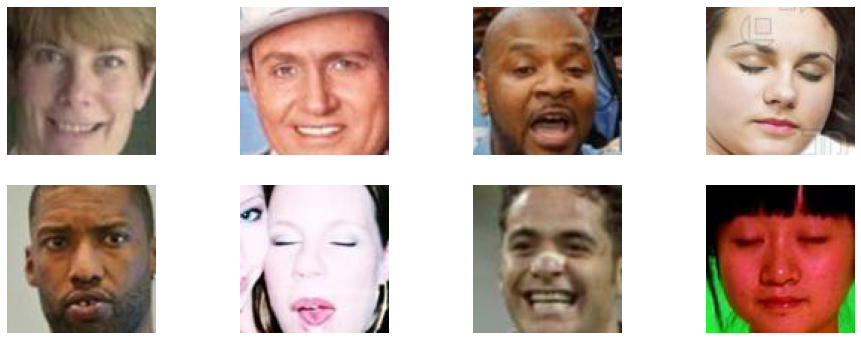

In [11]:
train_generator , val_generator, test_generator = collect_face_generators(False)
X_train, y_train = extract_x_y_data_from_generator(val_generator)
display_images_from_X_data(X_train, model_type = "face", n_rows=2, n_cols=4)


# Facial Image Model No Data Augmentation



[INFO] loading images...
[INFO] Training data info:
Found 1559 images belonging to 2 classes.
[INFO] Validation data info:
Found 389 images belonging to 2 classes.
[INFO] Testing data info:
Found 485 images belonging to 2 classes.
[INFO] Training face model
[INFO] PGD pipeline started.
[INFO] Initialize Neural Network
[INFO] Training network for 4 epochs...
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] The Keras Classifier has 2 classes


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '



Accuracy test set: 79.18%
Accuracy on original PGD adversarial samples: 79.18%
Accuracy on new PGD adversarial samples: 81.03%
[INFO] Classification Report for adversarially trained model: face
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       239
           1       0.82      0.80      0.81       246

    accuracy                           0.81       485
   macro avg       0.81      0.81      0.81       485
weighted avg       0.81      0.81      0.81       485

[INFO] PGD pipeline finished.
[INFO] Training face model
[INFO] FGSM pipeline started.
[INFO] Initialize Neural Network
[INFO] Training network for 4 epochs...
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] The Keras Classifier has 2 classes
(485, 100, 100, 1) 4850000
(485, 100, 100, 1) 4850000



Accuracy test set: 49.28%
Accuracy on original FGSM adversarial samples: 49.28%
Accuracy on new FGSM adversarial samples: 49.28%
[INFO] Classification Report for adversarially trained model: face
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       239
           1       0.00      0.00      0.00       246

    accuracy                           0.49       485
   macro avg       0.25      0.50      0.33       485
weighted avg       0.24      0.49      0.33       485

[INFO] FGSM pipeline finished.
[INFO] Training face model
[INFO] DeepFool pipeline started.
[INFO] Initialize Neural Network


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[INFO] Training network for 4 epochs...
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] The Keras Classifier has 2 classes



(485, 100, 100, 1) 4850000
(485, 100, 100, 1) 4850000



Accuracy test set: 63.71%
Accuracy on original DeepFool adversarial samples: 62.47%
Accuracy on new DeepFool adversarial samples: 52.58%
[INFO] Classification Report for adversarially trained model: face
              precision    recall  f1-score   support

           0       0.54      0.24      0.33       239
           1       0.52      0.80      0.63       246

    accuracy                           0.53       485
   macro avg       0.53      0.52      0.48       485
weighted avg       0.53      0.53      0.48       485

[INFO] DeepFool pipeline finished.


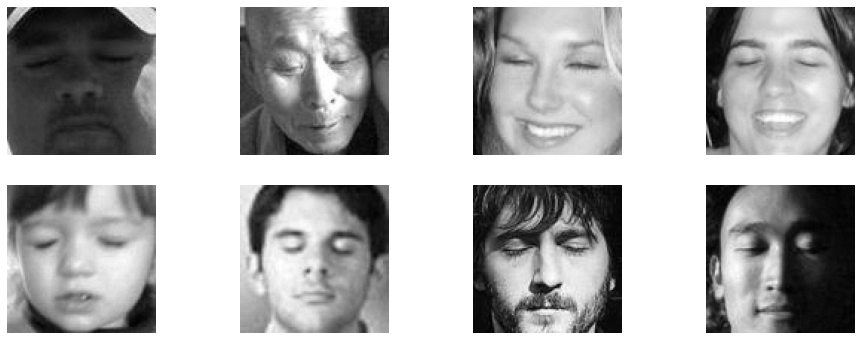

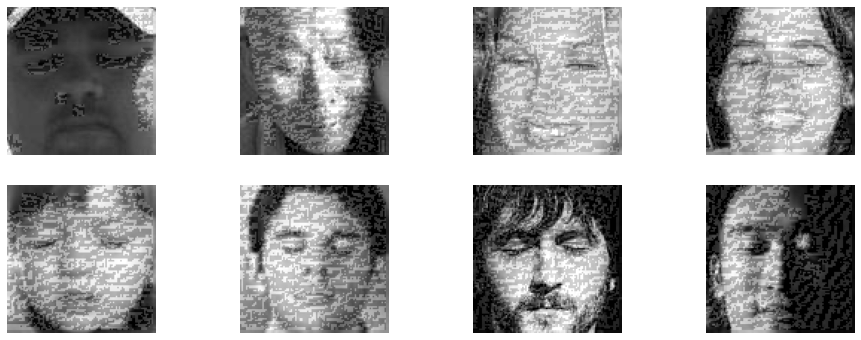

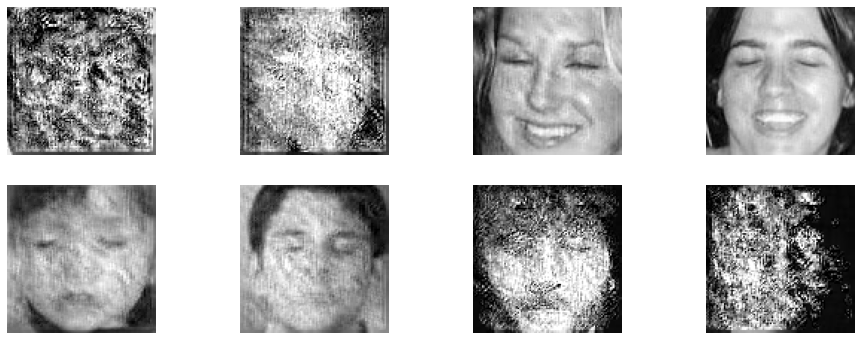

In [9]:
train_generator , val_generator, test_generator = collect_face_generators(False)
# X_train, y_train = extract_x_y_data_from_generator(val_generator)
# history = train(train_generator,val_generator, model_type="eye")
# plot_training_loss(history)
# eye_model = load_model('eye')
# print(eye_model.summary())
# predict_with_generator(train_generator, test_generator, model_type="eye")
# evaluate(val_generator, model_type="eye")

adversarial_train_on_PGD(train_generator, test_generator, model_type="face")
adversarial_train_on_FGSM(train_generator, test_generator, model_type="face")
adversarial_train_on_DeepFool(train_generator, test_generator, model_type="face")

# Face Model - With Data Augmentation

In [ ]:
train_generator , val_generator, test_generator = collect_face_generators(True) # Set to True for data augmentation
# X_train, y_train = extract_x_y_data_from_generator(val_generator)
# history = train(train_generator,val_generator, model_type="eye")
# plot_training_loss(history)
# eye_model = load_model('eye')
# print(eye_model.summary())
# predict_with_generator(train_generator, test_generator, model_type="eye")
# evaluate(val_generator, model_type="eye")

adversarial_train_on_PGD(train_generator, test_generator, model_type="face")
adversarial_train_on_FGSM(train_generator, test_generator, model_type="face")
adversarial_train_on_DeepFool(train_generator, test_generator, model_type="face")

[INFO] Data is augmented.
[INFO] loading images...
[INFO] Training data info:
Found 1559 images belonging to 2 classes.
[INFO] Validation data info:
Found 389 images belonging to 2 classes.
[INFO] Testing data info:
Found 485 images belonging to 2 classes.
[INFO] Training face model
[INFO] PGD pipeline started.
[INFO] Initialize Neural Network
[INFO] Training network for 4 epochs...
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] The Keras Classifier has 2 classes


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '



Accuracy test set: 71.96%
Accuracy on original PGD adversarial samples: 71.96%
Accuracy on new PGD adversarial samples: 71.96%
[INFO] Classification Report for adversarially trained model: face
              precision    recall  f1-score   support

           0       0.93      0.46      0.62       239
           1       0.65      0.97      0.78       246

    accuracy                           0.72       485
   macro avg       0.79      0.72      0.70       485
weighted avg       0.79      0.72      0.70       485

[INFO] PGD pipeline finished.
[INFO] Training face model
[INFO] FGSM pipeline started.
[INFO] Initialize Neural Network
[INFO] Training network for 4 epochs...
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] Generator has 485 files
X data size: 485. y data size:485
[INFO] The Keras Classifier has 2 classes
(485, 100, 100, 1) 4850000
(485, 100, 100, 1) 4850000


# Turn on Webcam to capture an image and test the models on the captured images
The code below turns on the webcam in Google Colab. Captures an image and the image can be tested against the model.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
# https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename, binary

# from IPython.display import Image
import io
from PIL import Image
model_type = 'face' # 'eye'

def capture_and_display_image():
    try:
        filename, binary = take_photo()
        print('[INFO] Saved to {}'.format(filename))
        img = Image.open(io.BytesIO(binary))
        # Show the image which was just taken.
        display(img)
        return img
    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not
        # grant the page permission to access it.
        print(str(err))
    

from PIL import Image
from numpy import asarray
from keras.preprocessing.image import img_to_array

def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "L":
        image = image.convert("L")

    # resize the input image and preprocess it
    image = image.resize(target)
    
    image = img_to_array(image)
    image /= 255
    image = np.expand_dims(image, axis=0)

    # return the processed image
    return image


# preprocess the image and prepare it for classification
def classify_from_webcam(model_type):
    assert model_type in ["eye", "face"], "[INFO] Invalid input. Accepted inputs: 'eye' or 'face'"
    img = capture_and_display_image()
    loaded_model = load_model(model_type)
    IMG_SIZE = determine_img_size_from_model_type(model_type)
    image = prepare_image(img, target=(IMG_SIZE,IMG_SIZE))
    prediction = loaded_model.predict(image)
    print("[INFO] Probability of eye being open:", prediction)
    if prediction < 0.5:
        predicted_label = 'closed'
    elif prediction >= 0.5:
        predicted_label = 'open'
    print("[INFO] Predicted label: {}".format(predicted_label))

In [ ]:
classify_from_webcam("eye")
classify_from_webcam("face")

# Turn on Webcam to capture  the video stream and test the models on the video stream
Below code is **buggy and won't work**. It intended to turn on the webcam in Google Colab. Captures the video stream and tests it against the model. Note: There are some bugs in the code below, so video feature doesn't work for now. It is also not part of the research paper since I was just experimenting with the JavaScript and Google Collab integration.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
# https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
# JS imports in Python's Google Collab is making the function name as undefined. 
# To truly test this, one might need to 
# adapt this code to be tensorflowjs compatible and test it outside of this function.
def capture_video_stream(filename='photo.jpg', quality=1):
  js = Javascript('''
//    import * as tf from '@tensorflow/tfjs';
//       import * as tfd from '@tensorflow/tfjs-data';
   async function takePhoto(quality) {
     
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.id = 'webcam'
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    // import * as tf from '@tensorflow/tfjs';
    // import * as tfd from '@tensorflow/tfjs-data';
    // // A webcam iterator that generates Tensors from the images from the webcam.
    // let webcam;
    // async function loadCustomModel() {
    // const sleepnet = await tf.loadLayersModel(
    //   'model-face.json'
    //   );

    //  return sleepnet
    // }
    // let isPredicting = false;
    // async function init() {
    //     const div = document.createElement('div');
    //     const predictButton = document.createElement('button');
    //     predictButton.textContent = 'Predict';
    //     div.appendChild(predictButton);

    //     const video = document.createElement('video');
    //     video.id = 'webcam'
    //     video.style.display = 'block';
    //     video.videoWidth = 224
    //     video.videoHeight = 224
    //     try {
    //         webcam = await tfd.webcam(document.getElementById('webcam'));
    //     } catch (e) {
    //         console.log(e);
    //         document.getElementById('no-webcam').style.display = 'block';
    //     }
    //         truncatedCustomModel = await loadCustomModel();
    //         truncatedCustomModel.predict(webcam)

    //     // Warm up the model. This uploads weights to the GPU and compiles the WebGL
    //     // programs so the first time we collect data from the webcam it will be
    //     // quick.
    //     const screenShot = await webcam.capture();
    //     truncatedCustomModel.predict(screenShot.expandDims(0));
    //     screenShot.dispose();
    // }

    // /**
    //  * Captures a frame from the webcam and normalizes it between -1 and 1.
    //  * Returns a batched image (1-element batch) of shape [1, w, h, c].
    //  */
    // async function getImage() {
    // const img = await webcam.capture();
    // const processedImg =
    //     tf.tidy(() => img.expandDims(0).toFloat().div(127).sub(1));
    // img.dispose();
    // return processedImg;
    // }


    // async function takePhoto(quality) {
    //   const div = document.createElement('div');
    //   const predictButton = document.createElement('button');
    //   predictButton.textContent = 'Predict';
    //   div.appendChild(predictButton);

    
    //   // Resize the output to fit the video element.
    //   google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

    //   // Wait for Capture to be clicked.
    //   await new Promise((resolve) => capture.onclick = resolve);

    //   const canvas = document.createElement('canvas');
    //   canvas.width = video.videoWidth;
    //   canvas.height = video.videoHeight;
    //   canvas.getContext('2d').drawImage(video, 0, 0);
    //   stream.getVideoTracks()[0].stop();
    //   div.remove();
    //   return canvas.toDataURL('image/jpeg', quality);
    // }

    // document.getElementById('predict').addEventListener('click', () => {
    //     isPredicting = true;
    //     predict();
    // });
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
    f.write(binary)
    return filename, binary

  # from IPython.display import Image
import io
from PIL import Image
model_type = 'face' # 'eye'
try:
  filename, binary = capture_video_stream()
  if model_type == 'face':
      IMG_SIZE = 100
      loaded_model = load_model('face')
  elif model_type == 'eye':
      IMG_SIZE= 24
      loaded_model = load_model('eye')

  print('Saved to {}'.format(filename))
  img = Image.open(io.BytesIO(binary))
  # Show the image which was just taken.
  display(img)
  # Predict the eyes closed or not
#   predicted = predict(img, loaded_model)
#   print(predicted)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))